### Reproducibility

In [ ]:
# Code block generated with Gemini; prompt "All seeds needed for reproducibility in pytorch based DL project"

import os
import random
import numpy as np
import torch

def set_all_seeds(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

set_all_seeds(42)

### Data Exploration

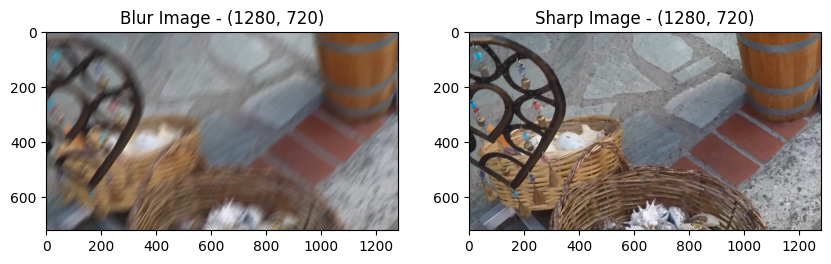

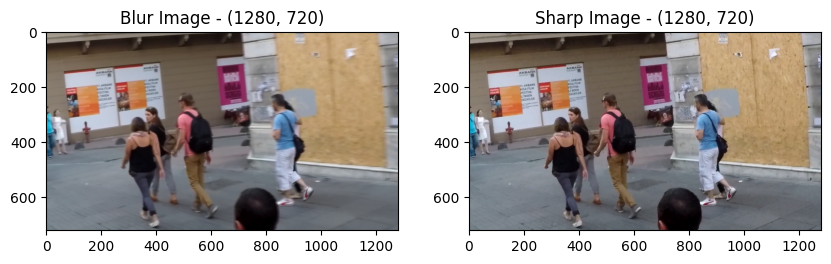

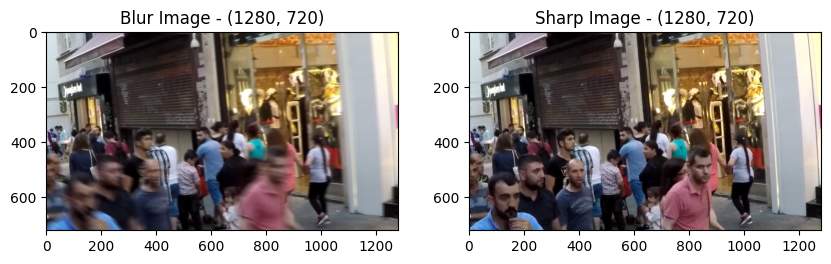

Total blur images: 1029
Total sharp images: 1029


In [2]:
from PIL import Image
import random, os
import matplotlib.pyplot as plt

root_dir = "gopro_deblur/"

def choose_and_plot_random_blur_and_unblur(root_dir):
    selected_blur_file = random.choice(os.listdir(os.path.join(root_dir, "blur/images")))
    blur_image_filename = os.path.join(root_dir, "blur/images", selected_blur_file)
    sharp_image_filename = os.path.join(root_dir, "sharp/images", selected_blur_file)
    # print(blur_image_filename, sharp_image_filename)
    blur_image = Image.open(blur_image_filename)
    sharp_image = Image.open(sharp_image_filename)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(blur_image)
    axs[1].imshow(sharp_image)

    axs[0].set_title(f'Blur Image - {blur_image.size}')
    axs[1].set_title(f'Sharp Image - {sharp_image.size}')
    plt.show()



choose_and_plot_random_blur_and_unblur(root_dir)
choose_and_plot_random_blur_and_unblur(root_dir)
choose_and_plot_random_blur_and_unblur(root_dir)

print(f"Total blur images: {len(os.listdir(os.path.join(root_dir, 'blur/images')))}")
print(f"Total sharp images: {len(os.listdir(os.path.join(root_dir, 'sharp/images')))}")

- ### All images are 1280x720 in size and there are 1029 images in both categories

### Trying to quantify BLUR-ness with FFT operator
- This lets us extract images with high blur, medium blur and low blur
- Ratio between high frequency and low frequency tells us how much blur is there in the image.

NOTE: This method works much better for motion-blur, while laplacian works much better for out-of-focus blur.

In [ ]:
import cv2
from tqdm import tqdm
import numpy as np

def calculate_blur_score_laplacian(file_path, radius=30):
    img = cv2.imread(file_path, 0)
    rows, cols = img.shape
    crow, ccol = rows // 2 , cols // 2
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft) # this function helps shift all the zero freq points to centre
    magnitude_spectrum = np.abs(dft_shift)
    mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), radius, 1, -1)
    low_freq_area = magnitude_spectrum * mask
    high_freq_area = magnitude_spectrum * (1 - mask)
    low_energy = np.sum(low_freq_area)
    high_energy = np.sum(high_freq_area)
    ratio = high_energy / low_energy
    return ratio

root_dir = "/home/nam/projects/sid/Motion-Deblurring/gopro_deblur/blur/images"
image_and_blur_score = []

for file in tqdm(os.listdir(root_dir)):
    full_path = os.path.join(root_dir, file)
    blur_score = calculate_blur_score_laplacian(full_path).item()
    image_and_blur_score.append([full_path, round(blur_score, 3)])

# Sorting in descending order according to blur_score, so that we can then split this into buckets of low, medium and high
# A high ratio means the image is sharp
sorted_blur_scores = sorted(image_and_blur_score, key=lambda x: x[1], reverse=True)

100%|██████████| 1029/1029 [00:44<00:00, 22.89it/s]


### Plotting Most Blur, Mid Blur and Least Blur

343 343 343


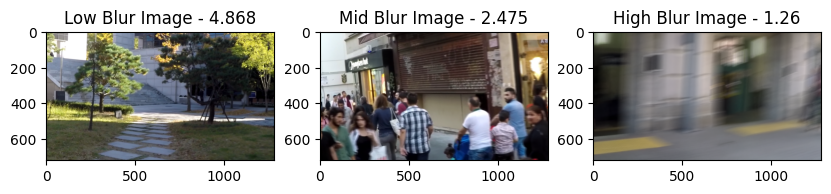

In [ ]:
low_idx = len(sorted_blur_scores)//3
mid_idx = (len(sorted_blur_scores)*2)//3
high_idx = len(sorted_blur_scores)

low_blur_bucket, mid_blur_bucket, high_blur_bucket = sorted_blur_scores[:low_idx], sorted_blur_scores[low_idx:mid_idx], sorted_blur_scores[mid_idx:high_idx]
print(len(low_blur_bucket), len(mid_blur_bucket), len(high_blur_bucket))

low_blur_sample = low_blur_bucket[0]
mid_blur_sample = mid_blur_bucket[110]
high_blur_sample = high_blur_bucket[-1]

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(Image.open(low_blur_sample[0]))
axs[1].imshow(Image.open(mid_blur_sample[0]))
axs[2].imshow(Image.open(high_blur_sample[0]))

axs[0].set_title(f'Least Blur Image - {low_blur_sample[1]}')
axs[1].set_title(f'Mid Blur Image - {mid_blur_sample[1]}')
axs[2].set_title(f'Highest Blur Image - {high_blur_sample[1]}')
plt.show()

### Plotting random samples from all 3 buckets

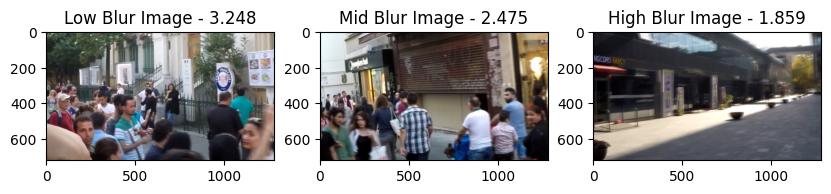

In [27]:
low_blur_sample = random.choice(low_blur_bucket)
mid_blur_sample = random.choice(mid_blur_bucket)
high_blur_sample = random.choice(high_blur_bucket)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(Image.open(low_blur_sample[0]))
axs[1].imshow(Image.open(mid_blur_sample[0]))
axs[2].imshow(Image.open(high_blur_sample[0]))

axs[0].set_title(f'Low Blur Image - {low_blur_sample[1]}')
axs[1].set_title(f'Mid Blur Image - {mid_blur_sample[1]}')
axs[2].set_title(f'High Blur Image - {high_blur_sample[1]}')
plt.show()